1* def_f: 
 0.19947114020071635 0.19888251077513006
2* def_f: 
 0.3989422804014327 0.39945598936202437
3* def_f: 
 0.5984134206021491 0.5990603371213273


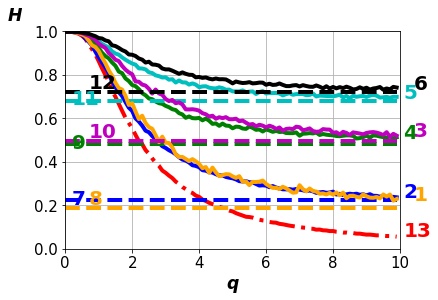

In [2]:
# рис. 10
import numpy as np
import math #для ln()
import matplotlib.pyplot as plt
from numpy import  exp, log, sqrt, pi
import random
from numpy import linalg # для собственные значения матрицы
import scipy.special as sc # для гипергеометрической функции Mhyper

M=100 #кол-во усреднений для оценки КМ-цы
N=10 #длина выборки (число компонент сигнала)
f=0 #частота сигнала
A = np.arange(0,10,0.1)

# Корреляционная матрица R 
def R0(N, alfa, iii):
    Ф = np.zeros((N,N), dtype=np.float64)
    for m in range(N):
        for n in range(N):
            Ф[m,n] = exp((-1*(m-n)**2)/(1/(alfa**2) * N**2))       
    Г = np.zeros((N,N), dtype=np.float64)
    Г[0,0] = sqrt(Ф[0,0])    
    for i in range(N):
        for j in range(i+1):
            Sum2=0
            if j!=0:
                for p in range(j):
                    Sum2+= Г[i,p]*np.conj(Г[j,p])
            #чтобы не было деления на 0
            if Г[j,j] ==0:
                Г[j,j]=0.0000001

            Г[i,j]=(Ф[i,j]-Sum2)/Г[j,j]
            
            Sum3=0
            if i!=0:
                for q in range(i):
                    Sum3+= abs(Г[i,q])**2
            c=Ф[i,i]-Sum3 
            if c<10**(-20):
                c=0
            Г[i,i]=pow(c, 0.5)
    if iii==0: return Г
    elif iii==1: return Ф

#возвращает Массив случайных комплексных чисел <class 'numpy.ndarray'>
def rnorm(N,mu,sigma):
    arr = np.array([])
    for i in range(N):
        a=random.gauss(mu, sigma)
        b=random.gauss(mu, sigma)
        arr = np.append(arr , complex(a,b))
    return arr

def rnorm_1(N,mu,sigma):
    arr = np.array([])
    for i in range(N):
        a=random.gauss(mu, sigma)
        arr = np.append(arr , a)
    return arr

def H10(A, alfa):
    G=np.array(R0(N,alfa,0)) #верно
    R = np.zeros((M*N,N,N),dtype=np.complex128)#Корреляционная матрица пришедшего сигнала
    for i in range(N*M):
        S0 = np.array([])
        Noise =  rnorm(N,0,1)
        c=np.array(rnorm_1(N,0,1))
        ASHP= G.dot(c) # умножение матрицы G на матрицу c
        for k in range(N):
            S0 = np.append(S0 , Noise[k]+(A*ASHP[k]))
        #транспонированная матрица
        S=np.array([S0]).T
        #комплексно-сопряженная матрица
        S_h= np.conj(S0)
        R[i]=S*S_h 
    I=np.identity(N) # создание единичной матрицы размера N*N
    RRR  = np.zeros((N,N),dtype=np.complex128)
    for i in range(N*M):
        RRR=RRR+R[i]
    RRR  = RRR/(N*M) 
    RRR_I = np.matrix(RRR)+np.matrix(0.1*I)
    #собственные значения матрицы (RRR + 0.1*I)
    EV=linalg.eig(RRR_I)[0]
    sum_EV=0
    for i in range(N): sum_EV += abs(EV[i])
    AN=EV/abs(sum_EV)    
    E=0
    for i in range(N): E += - abs(AN[i])*math.log(abs(AN[i]))
    return E

def H10_gr(A,alfa):
    gr=[]
    for i in range(len(A)): 
        gr.append(H10(A[i],alfa))
    return gr

# Энтропия: детерминированный сигнал + собственный шум без флуктуаций 
def H0(A,f):
    R = np.zeros((M*N,N,N),dtype=np.complex128)#Корреляционная матрица пришедшего сигнала
    for i in range(N*M):
        S0 = np.array([])
        Noise =  rnorm(N,0,1)
        for k in range(N):
            S0 = np.append(S0 , Noise[k]+A*exp(2j*math.pi*f*k/N))
        #транспонированная матрица
        S=np.array([S0]).T
        #комплексно-сопряженная матрица
        S_h= np.conj(S0)
        R[i]=S*S_h 
    RRR  = np.zeros((N,N),dtype=np.complex128)
    for i in range(N*M):
        RRR=RRR+R[i]
    RRR  = RRR/(N*M) 
    #собственные значения матрицы RRR
    L=linalg.eig(RRR)[0] 
    EV=L
    sum_EV=0
    for i in range(N): sum_EV += abs(EV[i])
    AN=EV/abs(sum_EV)    
    E=0
    for i in range(N): E+= - abs(AN[i])*math.log(abs(AN[i]))
    return E

def H0_gr(A,f):
    gr=[]
    for i in range(len(A)): 
        gr.append(H0(A[i], f))
    return gr

# Энтропия: детерминированный сигнал со случайной частотой + собственный шум
# sigma_f - это СКО случайных частот, распределенных по нормальному закону
def H8(A, sigma_f):
    R = np.zeros((M*N,N,N),dtype=np.complex128) # Корреляционная матрица пришедшего сигнала
    for i in range(N*M):
        S0 = np.array([])
        Noise =  rnorm(N,0,1)
        w = rnorm_1(N,0, sigma_f)  #случайные частоты, распределенные по нормальному закону
        for k in range(N):
            S0 = np.append(S0 , Noise[k]+A*exp(1j*(2*math.pi*(f+ w[k])*k/N )))
        #транспонированная матрица
        S=np.array([S0]).T
        #комплексно-сопряженная матрица
        S_h= np.conj(S0)
        R[i]=S*S_h 
    RRR  = np.zeros((N,N),dtype=np.complex128)
    for i in range(N*M):
        RRR=RRR+R[i]
    RRR  = RRR/(N*M)
    #собственные значения матрицы RRR
    L=linalg.eig(RRR)[0] 
    EV=L
    sum_EV=0
    for i in range(N): sum_EV+=abs(EV[i])
    AN=EV/sum_EV
    E=0
    for i in range(N): E+= - abs(AN[i])*math.log(abs(AN[i]))
    return E

def H8_gr(A,sigma_f):
    gr=[]
    for i in range(len(A)): 
        gr.append(H8(A[i], sigma_f))
    return gr

# энтропия матрицы R0
def E0(alfa):
    S0=np.array(R0(N,alfa,1))
    #собственные значения матрицы 
    EV=linalg.eig(S0)[0]
    sum_EV=0
    for i in range(N): sum_EV += EV[i]
    AN=EV/abs(sum_EV)
    E=0
    for i in range(N): E += - abs(AN[i])*math.log(abs(AN[i]))
    return E

def E(A, Alfa):
    EE=[]
    for i in range(len(A)):
        EE.append(E0(Alfa))
    return EE

del_f = 1
def c(n):
    return (n*del_f)/(2*sqrt(2*pi))
def F1(q_0n):
    Mhyper=sc.hyp1f1(1/2, 1, -q_0n**2/2) 
    return Mhyper
    
q01=4.15
q02=2.285
q03=1.55
print("1* def_f: \n" , c(1), F1(q01))
print("2* def_f: \n" , c(2), F1(q02))
print("3* def_f: \n" , c(3), F1(q03))

a1=H0(q01, f)
a2=H0(q02, f)
a3=H0(q03, f)

def E01(A,q01): 
    a11=[]
    for i in range(len(A)):
        a11.append(a1)
    return a11

def E02(A,q02): 
    a22=[]
    for i in range(len(A)):
        a22.append(a2)
    return a22

def E03(A,q03): 
    a33=[]
    for i in range(len(A)):
        a33.append(a3)
    return a33


delta_f=1/N 
alfa=3 

sigmas = [ 1, 2, 3] # СКО случайных частот
labels1=['2','4', '5', '7', '9', '11']
colors1=['b', 'g', 'c', 'b', 'g', 'c']
labels2=['1','3', '6', '8', '10', '12']
colors2=['orange', 'm', 'black', 'orange', 'm', 'black']

fig, ax = plt.subplots()

gr=H0_gr(A,1)/log(N)
ax.plot(A, gr,'red' , linestyle = '-.', label='13', linewidth=4)
plt.axis([0, 10, 0, 1])
xmin, xmax, ymin, ymax = plt.axis()
plt.text(xmax+0.1, min(gr), '13', color ='red' , fontsize = 20, fontweight='bold')

for i in range(len(sigmas)):
    gr=H8_gr(A, sigmas[i]*delta_f)/log(N)
    ax.plot(A, gr,colors1[i], label=labels1[i], linewidth=4 )
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    x_text = xmax+0.1
    plt.text(x_text, min(gr), labels1[i], color =colors1[i] , fontsize = 20, fontweight='bold')

gr=E01(A,q01)/log(N)
ax.plot(A, gr,colors1[3],linestyle = 'dashed', label=labels1[3], linewidth=4 )
xmin, xmax, ymin, ymax = plt.axis()
x_text = xmin+0.2
plt.text(x_text, min(gr)-0.02, labels1[3], color =colors1[3] , fontsize = 20, fontweight='bold')

gr=E02(A,q02)/log(N)
ax.plot(A, gr,colors1[4],linestyle = 'dashed', label=labels1[4], linewidth=4 )
xmin, xmax, ymin, ymax = plt.axis()
x_text = xmin+0.2
plt.text(x_text, min(gr)-0.02, labels1[4], color =colors1[4] , fontsize = 20, fontweight='bold')

gr=E03(A,q03)/(log(N))
ax.plot(A, gr,colors1[5],linestyle = 'dashed', label=labels1[5], linewidth=4 )
xmin, xmax, ymin, ymax = plt.axis()
x_text = xmin+0.2
plt.text(x_text, min(gr)-0.02, labels1[5], color =colors1[5] , fontsize = 20, fontweight='bold')

for i in range(len(sigmas)):
    gr=H10_gr(A, sigmas[i]*sqrt(sigmas[i]))/log(N)
    ax.plot(A, gr,colors2[i], label=labels2[i], linewidth=4 )
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    x_text = xmax+0.4
    plt.text(x_text, min(gr), labels2[i], color =colors2[i] , fontsize = 20, fontweight='bold')
    
for i in range(len(sigmas)):
    sigm = sigmas[i]*sqrt(sigmas[i])
    gr=E(A, sigm)/log(N)
    ax.plot(A, gr,colors2[i+3], linestyle = 'dashed', label=labels2[i+3], linewidth=4 )
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmin+0.7, min(gr)+0.016, labels2[i+3], color =colors2[i+3] , fontsize = 20, fontweight='bold')

plt.xlabel('q', color='black',fontsize = 'xx-large', style = 'italic', weight=600, loc='center')
plt.ylabel('H', color='black',fontsize = 'xx-large',style = 'italic', weight=600 , rotation=0, y=1.03, labelpad=20)

plt.tick_params(labelsize = 15)
#plt.legend(loc = 'upper right', fontsize = 15)
plt.rcParams["figure.figsize"] = (15, 20) 
plt.grid(True)
plt.show()